In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)


import time

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Parameters

In [5]:
gamma = 5000
rho = 1.5 # Bend radius in m

beta = (1-1/gamma**2)**(1/2)

sigma_x = 50e-6
sigma_z  = 50e-6

# Entrance angle
phi = 0.1/rho

## code

In [ ]:
from csr2d.core2 import psi_s, psi_x0_hat
from scipy.interpolate import RectBivariateSpline
from numba import njit, vectorize, float64
from csr2d.kick2 import green_meshes_hat

In [ ]:
# Bypassing the beam, use smooth Gaussian distribution for testing

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

In [ ]:
nz = 205
nx = 103

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')

lambda_grid_filtered = lamb_2d(zm,xm)
lambda_grid_filtered_prime = lamb_2d_prime(zm,xm)

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes_hat(nz, nx, dz, dx, rho=rho, beta=beta)  


# Boundary terms code development

### Four methods are tested below

In [6]:
lambda_interp_rect = RectBivariateSpline(zvec, xvec, lambda_grid_filtered)  # lambda lives in the observation grid

def transient_calc_lambda_boundary(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_interp_rect):
        
    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    lambda_zi_vec = lambda_interp_rect.ev( z_observe - zi_vec, xvec )   
    psi_x_zi_vec = psi_x0_hat(zi_vec/2/rho, temp, beta, dx)
    Wx_zi =  np.dot(psi_x_zi_vec, lambda_zi_vec)

    lambda_zo_vec = lambda_interp_rect.ev( z_observe - zo_vec, xvec )   
    psi_x_zo_vec = psi_x0_hat(zi_vec/2/rho, temp, beta, dx)
    Wx_zo =  np.dot(psi_x_zo_vec, lambda_zo_vec)
    
    #return Wx_zi, Wx_zo
    return Wx_zi

In [7]:
from fast_interp import interp2d

zmin = np.min(zvec)
zmax = np.max(zvec)
xmin = np.min(xvec)
xmax = np.max(xvec)
    
lambda_interp = interp2d([zmin,xmin], [zmax,xmax], [dz,dx], lambda_grid_filtered,k=3) # lambda lives in the observation grid

# Use numba-accelerated interpolation 
def transient_calc_lambda_boundary_2(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_interp):


    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    # Results need a "(beta**2 / rho)*dx" factor
    lambda_zi_vec = lambda_interp( z_observe - zi_vec, xvec )   
    psi_x_zi_vec = psi_x0_hat(zi_vec/2/rho, temp, beta, dx)
    Wx_zi = np.dot(psi_x_zi_vec, lambda_zi_vec)

    lambda_zo_vec = lambda_interp( z_observe - zo_vec, xvec )   
    psi_x_zo_vec = psi_x0_hat(zo_vec/2/rho, temp, beta, dx)
    Wx_zo = np.dot(psi_x_zo_vec, lambda_zo_vec)

    
    #return Wx_zi, Wx_zo
    return Wx_zi

In [8]:
#cache=True
@njit(cache=True)
def transient_calc_lambda_boundary_new(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid):
    

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    # z positions at where the lambda-grid is to be eavluated
    zi_vec_eval = z_observe - zi_vec  
    zo_vec_eval = z_observe - zo_vec
    
    lambda_zi_vec = np.zeros(nx)
    lambda_zo_vec = np.zeros(nx)
    psi_x_zi_vec = np.zeros(nx)
    psi_x_zo_vec = np.zeros(nx)

    
    for i in range(nx):
        if (zi_vec_eval[i] < zvec[0]) | (zi_vec_eval[i] > zvec[-1]): # if the z falls outside the grid
            lambda_zi_vec[i] = 0
        else:
            lambda_zi_vec[i] = lambda_grid_filtered [np.argmin(np.abs(zvec - zi_vec_eval[i])), i]

        if (zo_vec_eval[i] < zvec[0]) | (zo_vec_eval[i] > zvec[-1]): # if the z falls outside the grid
            lambda_zo_vec[i] = 0
        else:
            lambda_zo_vec[i] = lambda_grid_filtered [np.argmin(np.abs(zvec - zo_vec_eval[i])), i]

            
        if (zi_vec[i] < zvec2[0]) | (zi_vec[i] > zvec2[-1]): # if the z falls outside the grid
            psi_x_zi_vec[i] = 0
        else:
            #zix = np.argmin(np.abs(zvec2/2/rho - zi_vec[i]/2/rho))
            zix = np.argmin(np.abs(zvec2 - zi_vec[i]))
            xix = np.argmin(np.abs(xvec2/rho - temp[i]))
            psi_x_zi_vec[i] = psi_x_grid [zix, xix]
    
        if (zo_vec[i] < zvec2[0]) | (zo_vec[i] > zvec2[-1]): # if the z falls outside the grid
            psi_x_zo_vec[i] = 0
        else:
            zix = np.argmin(np.abs(zvec2 - zo_vec[i]))
            xix = np.argmin(np.abs(xvec2/rho - temp[i]))
            psi_x_zo_vec[i] = psi_x_grid [zix, xix]
            
    
    # Results need a "(beta**2 / rho)*dx" factor
    Wx_zi = np.dot(psi_x_zi_vec, lambda_zi_vec)
    Wx_zo = np.dot(psi_x_zo_vec, lambda_zo_vec)

    
    return Wx_zi
    #return lambda_zi_vec

In [9]:
@njit(cache=True)
def transient_calc_lambda_boundary_new_2(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid):
    
    nx = xvec.shape[0]

    lambda_zi_vec = np.zeros(nx)
    lambda_zo_vec = np.zeros(nx)
    psi_x_zi_vec = np.zeros(nx)
    psi_x_zo_vec = np.zeros(nx)
   
    for i in range(nx):
        
        temp = (x_observe - xvec[i])/rho
        zi = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
        zo = -beta*np.abs(x_observe - xvec[i])

        # z positions at where the lambda-grid is to be eavluated
        zi_eval = z_observe - zi
        zo_eval = z_observe - zo
        
        if (zi_eval < zvec[0]) | (zi_eval > zvec[-1]): # if the z falls outside the grid
            lambda_zi_vec[i] = 0
        else:
            lambda_zi_vec[i] = lambda_grid_filtered [np.argmin(np.abs(zvec - zi_eval)), i]

        if (zo_eval < zvec[0]) | (zo_eval > zvec[-1]): # if the z falls outside the grid
            lambda_zo_vec[i] = 0
        else:
            lambda_zo_vec[i] = lambda_grid_filtered [np.argmin(np.abs(zvec - zo_eval)), i]

            
        if (zi < zvec2[0]) | (zi > zvec2[-1]): # if the z falls outside the grid
            psi_x_zi_vec[i] = 0
        else:
            #zix = np.argmin(np.abs(zvec2/2/rho - zi_vec[i]/2/rho))
            zix = np.argmin(np.abs(zvec2 - zi))
            xix = np.argmin(np.abs(xvec2/rho - temp))
            psi_x_zi_vec[i] = psi_x_grid [zix, xix]
    
        if (zo < zvec2[0]) | (zo > zvec2[-1]): # if the z falls outside the grid
            psi_x_zo_vec[i] = 0
        else:
            zix = np.argmin(np.abs(zvec2 - zo))
            xix = np.argmin(np.abs(xvec2/rho - temp))
            psi_x_zo_vec[i] = psi_x_grid [zix, xix]
            
    
    # Results need a "(beta**2 / rho)*dx" factor
    Wx_zi = np.dot(psi_x_zi_vec, lambda_zi_vec)
    Wx_zo = np.dot(psi_x_zo_vec, lambda_zo_vec)

    
    return Wx_zi

# Applying the codes

### Note that numba-jitted code are slower the FIRST time

In [10]:
t1 = time.time()
r1 = transient_calc_lambda_boundary(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx, lambda_interp_rect)
print(r1)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

-840740232.7055775
Mapping takes: 0.0013811588287353516 sec


In [12]:
t1 = time.time()
r2 = transient_calc_lambda_boundary_2(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx, lambda_interp )
print(r2)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

-840740631.5380152
Mapping takes: 0.0021932125091552734 sec


In [38]:
t1 = time.time()
r3 = transient_calc_lambda_boundary_new(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid )
print(r3)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

-840300912.6367007
Mapping takes: 0.0010037422180175781 sec


In [39]:
t1 = time.time()
r4 = transient_calc_lambda_boundary_new_2(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid)
print(r4)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

-840300912.6367007
Mapping takes: 0.0013773441314697266 sec


## super version for parallelism

In [13]:
def transient_calc_lambda_boundary_super(z_observe, x_observe):
    return transient_calc_lambda_boundary(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_interp_rect)

In [14]:
def transient_calc_lambda_boundary_super_2(z_observe, x_observe):
    return transient_calc_lambda_boundary_2(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_interp )

In [15]:
@vectorize([float64(float64,float64)] , target='parallel')
def transient_calc_lambda_boundary_super_new(z_observe, x_observe):
    return transient_calc_lambda_boundary_new(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid)

In [16]:
@vectorize([float64(float64,float64)], target='parallel' )
def transient_calc_lambda_boundary_super_new_2(z_observe, x_observe):
    return transient_calc_lambda_boundary_new_2(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, psi_x_grid)

In [17]:
# Quick test that mapping works
gaga = map(transient_calc_lambda_boundary_super, zm.flatten()[0:3], xm.flatten()[0:3])
np.array(list(gaga))

array([-10443.30002739, -10474.23151179, -10505.24774427])

In [18]:
t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=4) as executor:
    result = executor.map(transient_calc_lambda_boundary_super, zm.flatten(), xm.flatten())
    g1 = np.array(list(result))
    
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

Mapping takes: 18.99372410774231 sec


In [21]:
t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=4) as executor:
    result = executor.map(transient_calc_lambda_boundary_super_2, zm.flatten(), xm.flatten())
    g2 = np.array(list(result))
    
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
t1 = time.time()
g3 = transient_calc_lambda_boundary_super_new(zm,xm)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

In [ ]:
t1 = time.time()
transient_calc_lambda_boundary_super_new_2(zm,xm)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

NameError: name 'g2' is not defined

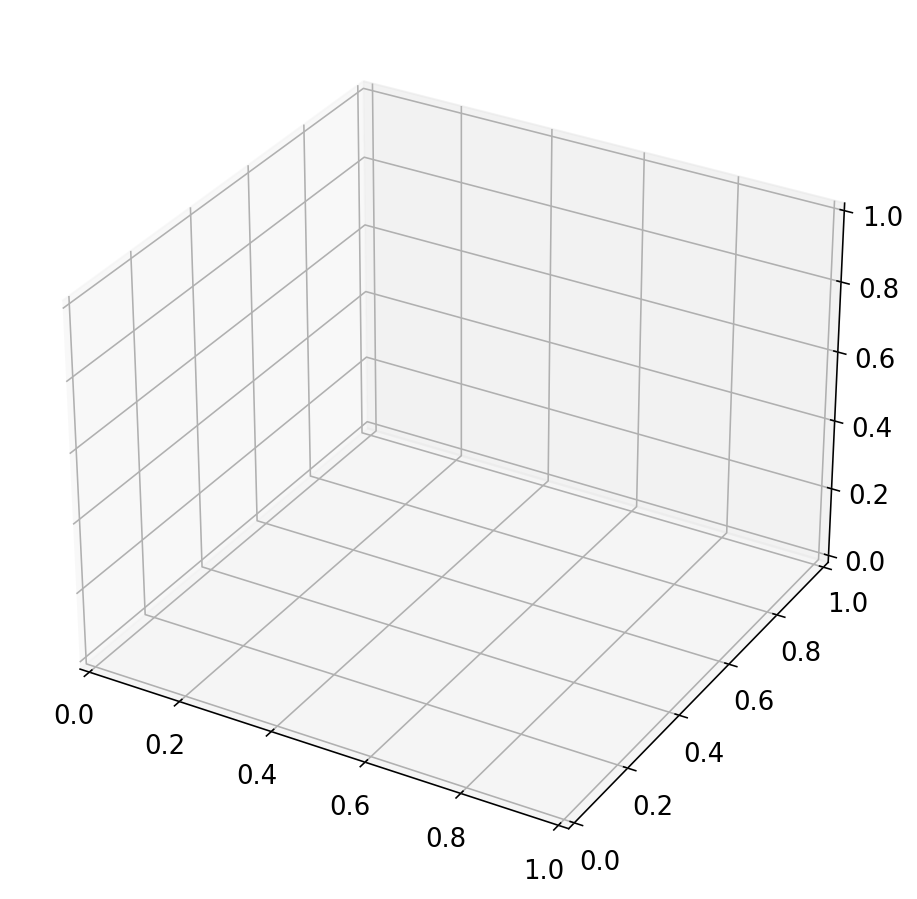

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm*1e5, xm*1e5, g3.reshape(zm.shape), cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')